# Yet Another NY Taxi demo

In this notebook, we'll set up a connection to IRIS and walk through a few exciting query results showcasing advances in IRIS SQL throughout 2022.1 and 2022.2. First, we're using IRIS DB-API to set up a connection to IRIS.

In [1]:
import iris, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

connection = iris.connect("localhost:51777/NYTAXI", "_SYSTEM", "SYS")

The following utility paragraph just suppresses usage warnings for pandas preferring SQLAlchemy over DB-API 

In [2]:
import warnings
warnings.simplefilter("ignore")

Now we'll set up a few utility functions we'll be using throughout the demo

In [3]:
# utility vars and function to compare metrics
last_time = 0
last_grefs = 0
plans = []

def reset_compare():
    global last_time, last_grefs
    last_time = 0
    last_grefs = 0

def brag(prev, new, speed=True):
    if ((prev == 0) or (new == 0) or (prev == new)):
        return ""
    if (prev > new):
        rate = prev / new
        if (rate > 2):
            return " - {:,.2f}x {}".format(rate, "faster" if speed else "less")
        else:
            return " - {:,.0%} {}".format(rate-1, "faster" if speed else "less")
    else:
        rate = new / prev
        if (rate > 2):
            return " - {:,.2f}x {}".format(rate, "slower" if speed else "more")
        else:
            return " - {:,.0%} {}".format(rate-1, "slower" if speed else "more")

def just_sql(sql):
    c1 = connection.cursor()
    c1.execute(sql)
    result = c1.fetchall()[0][0]
    c1.close()
    return result  

def query(sql, compare = True, dtypes = None):
    global last_time, last_grefs, plans
    
    plans.append(just_sql("EXPLAIN "+sql))
    
    start_grefs = just_sql("SELECT NYTaxi.GloRefs()")
    
    start_time = time.time()
    result = pd.read_sql_query(sql, connection, dtype = dtypes)
    exec_time = time.time() - start_time
    
    exec_grefs = just_sql("SELECT NYTaxi.GloRefs()") - start_grefs - 1
    
    if compare:
        print("\nExecution time: {:.3f}s ".format(exec_time) + brag(last_time, exec_time))
        print("Global references: {:,} ".format(exec_grefs) + brag(last_grefs, exec_grefs, False))
        last_time = exec_time
        last_grefs = exec_grefs
    else:
        print("\nExecution time: {:.3f}s\nGlobal references: {:,}".format(exec_time, exec_grefs))
    
    return result


## A first test to validate the connection


Execution time: 1.235s 
Global references: 1,248 


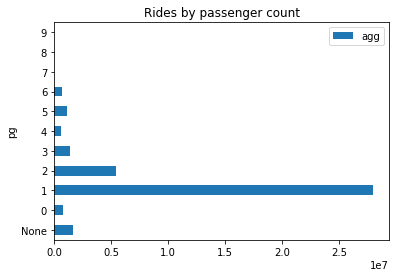

In [4]:
r = query("SELECT passenger_count AS pg, COUNT(*) AS agg "+
          "FROM NYTaxi.Rides "+
          "GROUP BY passenger_count")

r.plot.barh(x='pg',y='agg',title="Rides by passenger count");

## Adaptive Mode in SQL

Adaptive Mode includes RunTime PlanChoice, which we can disable for the sake of the demo by using `#NORUNTIME`

In [5]:
reset_compare()
r = query("SELECT %NORUNTIME AVG(total_amount) "+
             "FROM NYTaxi.RowRides2 "+
             "WHERE passenger_count > 2 "+
                   "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'")


Execution time: 21.771s 
Global references: 50,578,859 


Luckily it's ON by default, so we can just leave out that hint and get great out-of-the-box performance.

In [6]:
r = query("SELECT AVG(total_amount) "+
             "FROM NYTaxi.RowRides2 "+
             "WHERE passenger_count > 2 "+
                   "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'")


Execution time: 2.018s  - 10.79x faster
Global references: 2,490,971  - 20.30x less


The above speedup is realized by making proper use of advanced statistics collected by IRIS in 2022.1. In this particular case, we're relying on histograms that capture how our field values are distributed across rows. The chart below shows this information for the `tpep_pickup_datetime` field. 
As you'll note, almost all of the data is in our requested date range, so using the index on this supposedly selective field is not very helpful for this set of runtime parameters.


Execution time: 0.058s
Global references: 37,799


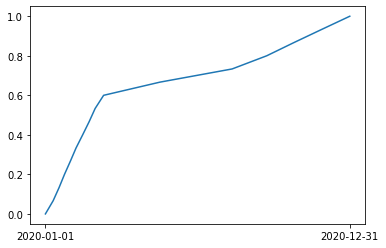

In [7]:
r = query("SELECT BUCKET_POSITION, PERCENTILE, VALUE, CAST((VALUE+0) AS POSIXTIME) AS DATE_VALUE "+
          "FROM INFORMATION_SCHEMA.COLUMN_HISTOGRAMS "+
          "WHERE TABLE_SCHEMA = 'NYTaxi' "+
                "AND TABLE_NAME = 'RowRides2' "+
                "AND COLUMN_NAME = 'tpep_pickup_datetime'", False)
plt.plot(r['VALUE'], r['PERCENTILE'])
plt.xticks(ticks=[r['VALUE'].min(), r['VALUE'].max()], 
           labels=[r['DATE_VALUE'].min()[0:10], r['DATE_VALUE'].max()[0:10]])
plt.show()

# Columnar Storage

Now let's run the very same query again, now targeting the columnar version of our table. 
Note the different table name in the `FROM` clause.

In [8]:
r = query("SELECT AVG(total_amount) "+
             "FROM NYTaxi.Rides "+
             "WHERE passenger_count > 2 "+
                   "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'")


Execution time: 0.210s  - 9.61x faster
Global references: 2,015  - 1,236.21x less


In [9]:
print(plans[-1])

<plans>
 <plan>
 <sql>
  SELECT AVG(total_amount) FROM NYTaxi.Rides WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31' /*#OPTIONS {"xDBCIsoLevel":"0"} */
 </sql>
 <cost value=""/>
 Call module C.
 From each parallel process:
     Accumulate the count([value]).
     Accumulate the sum([value]).
 <module name="C" top="1">
 Partition extent bitmap NYTaxi.Rides.%%DDLBEIndex, and in parallel, for each partition, looping on bitmap chunks.
 For each bitmap chunk:
     Read columnar index NYTaxi.Rides._CDM_tpeppickupdatetime, using the given chunk number.
     Apply vector and bitmap operations <=, >=, and & to produce a filter.
     Read columnar index NYTaxi.Rides._CDM_passengercount, using the given chunk number.
     Apply vector and bitmap operations >, &, defined, and & to produce a filter.
     Read columnar index NYTaxi.Rides._CDM_totalamount, using the given chunk number.
     Apply vector operations sum and count.
     Accumulate the sum([value])

That was just to show off, now let's look at some more decent examples

This query shows how far along we got in teaching the IRIS SQL engine to work with columnar storage. There's groupings, aggregates, order by and an outer JOIN!


Execution time: 11.106s 
Global references: 24,648,657 


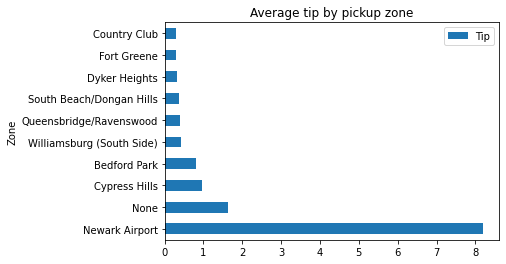

In [10]:
reset_compare()
r = query("SELECT Zone, Borough, Tip FROM ("+
              "SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) AS Tip "+
              "FROM NYTaxi.RowRides2 "+
              "WHERE fare_amount > 0 "+
              "GROUP BY PULocationID "+
              "ORDER BY 2 DESC"+
          ") r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID", 
          dtypes = { "Tip": np.double })

r.plot.barh(x="Zone", y="Tip", title="Average tip by pickup zone");


Execution time: 2.862s  - 3.88x faster
Global references: 1,764  - 13,973.16x less


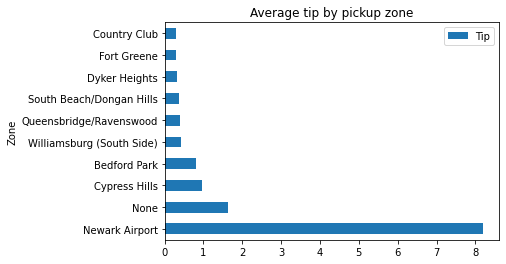

In [11]:
r = query("SELECT Zone, Borough, Tip FROM ("+
              "SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) Tip "+
              "FROM NYTaxi.Rides2 "+
              "WHERE fare_amount > 0 "+
              "GROUP BY PULocationID "+
              "ORDER BY 2 DESC"+
          ") r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID", 
          dtypes = { "Tip": np.double })

r.plot.barh(x="Zone", y="Tip", title="Average tip by pickup zone");

In [12]:
print(plans[-1])

<plans>
 <plan>
 <sql>
  SELECT Zone, Borough, Tip FROM (SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) Tip FROM NYTaxi.Rides2 WHERE fare_amount > 0 GROUP BY PULocationID ORDER BY 2 DESC) r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID /*#OPTIONS {"xDBCIsoLevel":"0"} */
 </sql>
 <cost value="55148"/>
 Call module H, which populates temp-file A.
 Read temp-file A, looping on AVG and a counter.
 For each row:
     Read index map NYTaxi.Zones.LocationID, using the given LocationID, and getting ID.
     Read master map NYTaxi.Zones.IDKEY, using the given idkey value.
     Generate a row padded with NULL for table NYTaxi.Zones if no row qualified.
     Output the row.
 <module name="H" top="1">
 Call module I.
 Read array temp-file B, looping on PULocationID.
 For each row:
     Read array temp-file C, using the given subscript values.
     Read array temp-file D, using the given subscript values.
     Add a row to temp-file A, subscripted by AVG and a counter,
      

The following query does some basic data quality style checking and would make sense to someone evaluating the data, but not at all be something your DBA would create an index for. It's an illustration of the _conversation_ you can have with big tables thanks to columnar storage.

In [13]:
reset_compare()
query("SELECT COUNT(*) AS TimeTravel "+
      "FROM NYTaxi.RowRides2 "+
      "WHERE tpep_pickup_datetime > tpep_dropoff_datetime")


Execution time: 6.080s 
Global references: 24,648,638 


,TimeTravel
0,19874


In [14]:
query("SELECT COUNT(*) AS TimeTravel "+
      "FROM NYTaxi.Rides2 "+
      "WHERE tpep_pickup_datetime > tpep_dropoff_datetime")


Execution time: 0.465s  - 13.08x faster
Global references: 1,456  - 16,929.01x less


,TimeTravel
0,19874


And now it's time to boast with some more spectacular differences


Execution time: 8.517s 
Global references: 24,648,638 


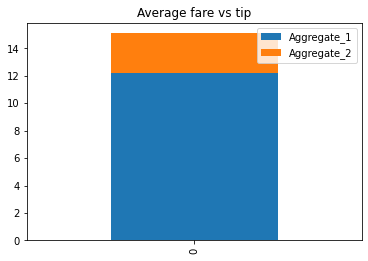

In [15]:
reset_compare()
r = query("SELECT AVG(fare_amount), AVG(tip_amount) "+
          "FROM NYTaxi.RowRides2 "+
          "WHERE payment_type = 1")

r.plot.bar(stacked=True, title="Average fare vs tip");


Execution time: 0.140s  - 60.84x faster
Global references: 1,741  - 14,157.75x less


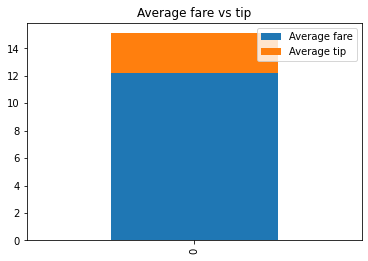

In [16]:
r = query("SELECT AVG(fare_amount) AS \"Average fare\", AVG(tip_amount) AS \"Average tip\" "+
          "FROM NYTaxi.Rides2 "+
          "WHERE payment_type = 1")

r.plot.bar(stacked=True, title="Average fare vs tip");